In [51]:
import pybaseball
import numpy as np
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import pandas as pd
from sklearn.metrics import mean_squared_error

# Scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def mean_absolute_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluates model on test data
def fit_and_eval(model, model_X_train, model_X_test, model_y_train, model_y_test, model_type,):    
    model.fit(model_X_train, model_y_train)
    
    model_pred = model.predict(model_X_test)

    model_mae = mean_absolute_error(model_y_test, model_pred)

    model_rmse = rmse(model_y_test, model_pred)
    
    tmp = pd.DataFrame({"True": model_y_test, "Pred": model_pred})
    
    sns.scatterplot(tmp,x="True", y="Pred").set_title(f"Comparing Prediction vs True for {model_type}")
    
    plt.show()
    
    return model_mae, model_rmse

# Return missing values by column
def missing_values(df):
        # Get all missing values
        missing_values = df.isnull().sum()
        
        # Returns total % that is missing
        missing_values_percent = 100 * df.isnull().sum() / len(df)
        
        missing_values_table = pd.concat([missing_values, missing_values_percent], axis=1)
        
        # Renaming the columns
        missing_values_table_rename_columns = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total'})
        
        # Sort the table by percentage of missing descending
        missing_values_table_rename_columns = missing_values_table_rename_columns[
            missing_values_table_rename_columns.iloc[:,1] != 0].sort_values(
        '% of Total', ascending=False).round(1)
        print ("Your DataFrame has " + str(df.shape[1]) + " columns.\n"      
            "It contains " + str(missing_values_table_rename_columns.shape[0]) +
              " columns with missing values.")
        
        # Return the df with missing info
        return missing_values_table_rename_columns

# Retrieve all statcast baseball data
all_data = pybaseball.batting_stats(2015, end_season=2022, qual=1)

training_data = all_data[all_data["Season"] < 2022]
target_data = all_data[all_data["Season"] > 2015]

In [52]:
missing_df = missing_values(training_data);
missing_columns = list(missing_df[missing_df['% of Total'] > 10].index)

Your DataFrame has 320 columns.
It contains 235 columns with missing values.


In [53]:
training_data = training_data.drop(columns = list(missing_columns))
training_data = training_data.drop(['Name', 'Team', 'Dol',  'Age Rng'], axis=1)

In [54]:
training_data = training_data.dropna()
# Ensure training and testing data is same length
if len(training_data) > len(target_data):
    training_data = training_data.iloc[0:len(target_data)]
else:
    target_data = target_data.iloc[0:len(training_data)]

training_data = training_data.astype(float)

In [55]:
# Determining which features have the highest correlation to the target
# 80 is a lot of features to keep, but model did worse when features were reduced
tmp = training_data.copy()
tmp.rename(columns={'HR' : 'Old_Homers'}, inplace=True)
new_df = pd.merge(tmp, target_data[['HR','IDfg']], on='IDfg')
# print(abs(new_df.corr()['HR']).sort_values(ascending=False).drop("Old_Homers").head(10))
correlations_data = abs(new_df.corr()['HR']).sort_values(ascending=False)
# Show Pearson Coefficient Correlation values to determine how dependent the variables are on each other
correlations_data = correlations_data.drop("HR").head(50)
correlations_data = correlations_data.rename({'Old_Homers' : 'HR'})
print(correlations_data.head(50))

HR          0.631117
Barrels     0.624829
RBI         0.601099
wRC         0.584291
HardHit     0.579266
+WPA        0.566519
Balls       0.563166
FB          0.562842
R           0.562202
Pitches     0.551954
BB          0.548781
Rep         0.544774
PA          0.541960
SO          0.541621
Strikes     0.540957
AB          0.533811
-WPA        0.530814
H           0.527823
2B          0.520311
Events      0.510114
ISO+        0.509119
ISO         0.507412
LD          0.488109
G           0.484079
L-WAR       0.477661
SLG+        0.474746
RAR         0.474541
WAR         0.473407
SLG         0.473140
IFFB        0.469175
maxEV       0.466613
wRAA        0.462483
GDP         0.461356
1B          0.460071
Barrel%     0.458997
GB          0.452742
OPS         0.452165
wFB         0.446155
WPA/LI      0.445583
wRC+        0.440629
wOBA        0.438556
Bat         0.437262
RE24        0.436126
REW         0.434632
SF          0.422362
Off         0.422155
HardHit%    0.410726
Lg          0

In [56]:
# Ensure features only has the relevant features
features = training_data[correlations_data.index].copy()
targets = pd.DataFrame(target_data['HR']).astype(float)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

In [57]:
# Make scaler object with range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)

# Transform training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
# Convert y to 1D array
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

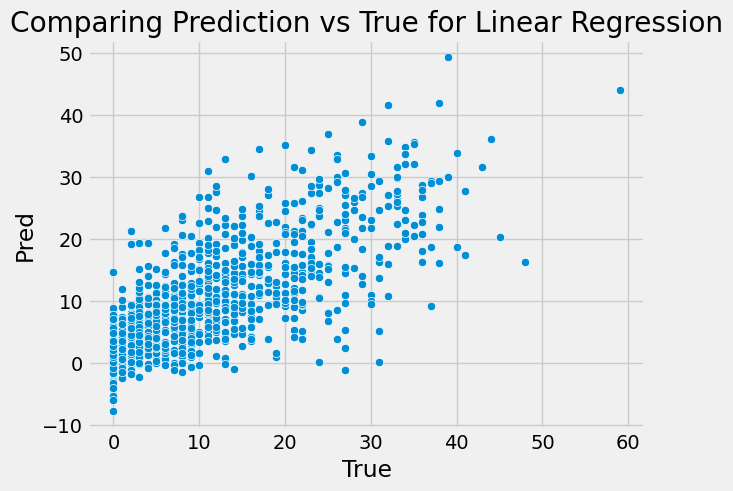

Linear Regression Performance on test set: MAE = 3.7401229907487816
Linear Regression Performance on test set: RMSE = 5.588990488393406


In [59]:
lin_reg = LinearRegression()
lin_reg_mae, lin_reg_rmse = fit_and_eval(lin_reg, X_train, X_test, y_train, y_test, "Linear Regression")

print(f'Linear Regression Performance on test set: MAE = {str(lin_reg_mae)}')
print(f'Linear Regression Performance on test set: RMSE = {str(lin_reg_rmse)}')

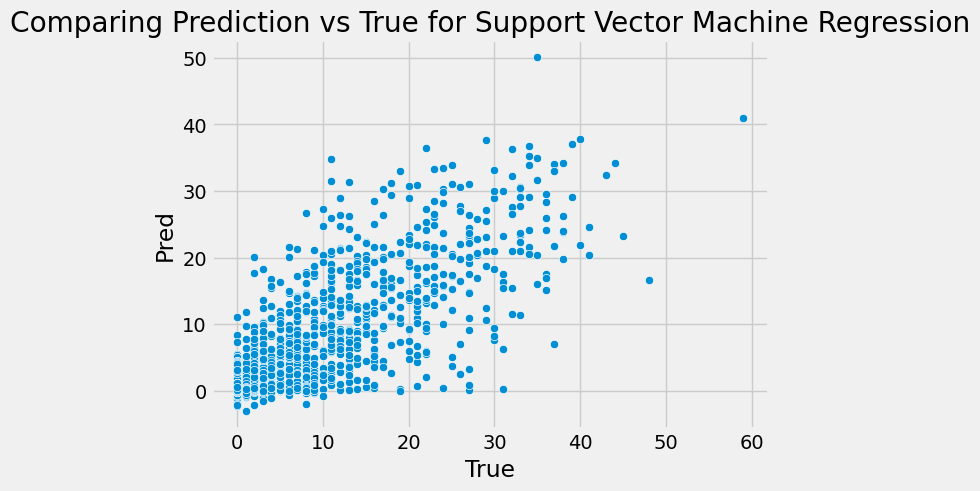

Support Vector Machine Regression Performance on test set: MAE = 3.362429173009793
Support Vector Machine Regression Performance on test set: RMSE = 5.715467647075646


In [60]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae, svm_rmse = fit_and_eval(svm, X_train, X_test, y_train, y_test, "Support Vector Machine Regression")
print(f'Support Vector Machine Regression Performance on test set: MAE = {str(svm_mae)}')
print(f'Support Vector Machine Regression Performance on test set: RMSE = {str(svm_rmse)}')

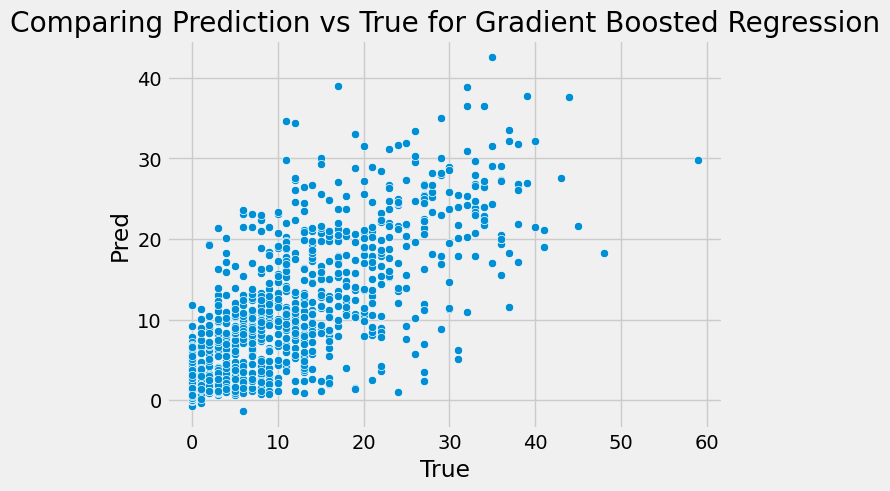

Gradient Boosted Regression Performance on test set: MAE = 3.395499600862685
Gradient Boosted Regression Performance on test set: RMSE = 5.451607601846786


In [61]:
grad_boost = GradientBoostingRegressor(random_state=100)
grad_boost_mae, grad_boost_rmse = fit_and_eval(grad_boost, X_train, X_test, y_train, y_test, "Gradient Boosted Regression")

print(f'Gradient Boosted Regression Performance on test set: MAE = {str(grad_boost_mae)}')
print(f'Gradient Boosted Regression Performance on test set: RMSE = {str(grad_boost_rmse)}')

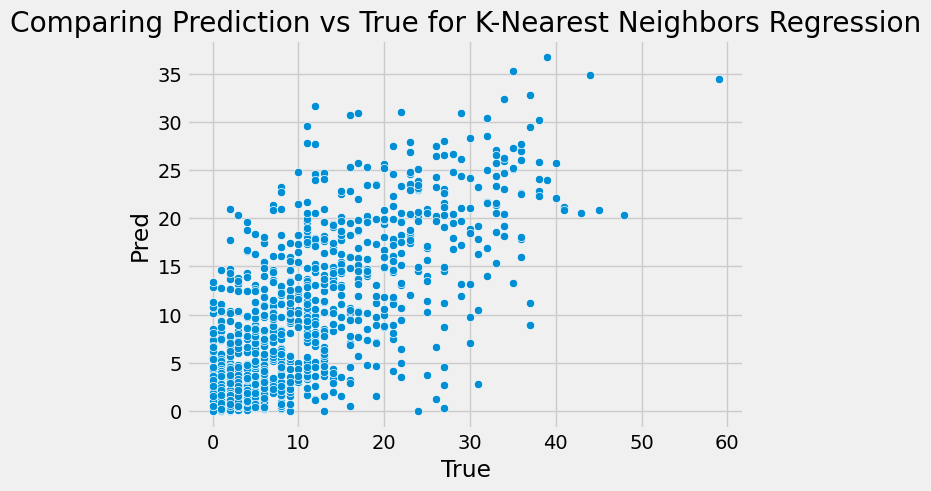

K-Nearest Neighbors Regression Performance on the test set: MAE = 3.684872417982989
K-Nearest Neighbors Regression Performance on test set: RMSE = 5.753356566922324


In [62]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae, knn_rmse = fit_and_eval(knn, X_train, X_test, y_train, y_test, "K-Nearest Neighbors Regression")

print(f'K-Nearest Neighbors Regression Performance on the test set: MAE = {str(knn_mae)}')
print(f'K-Nearest Neighbors Regression Performance on test set: RMSE = {str(knn_rmse)}')

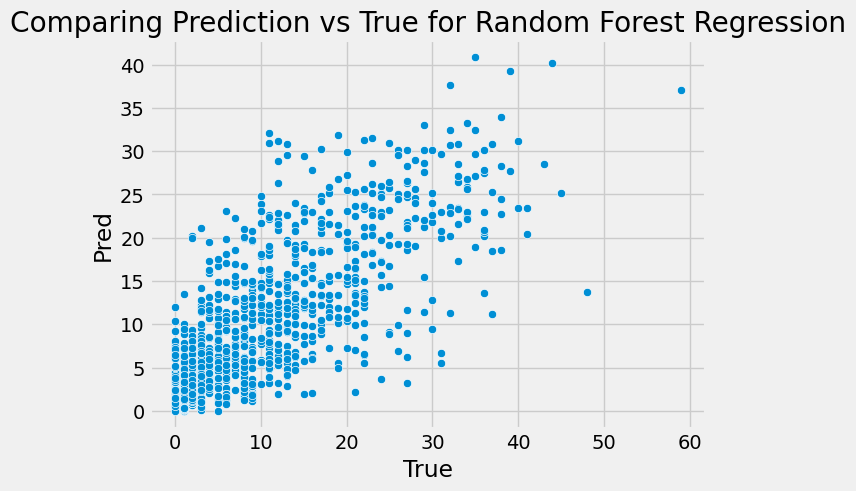

Random Forest Regression Performance on the test set: MAE = 3.1866646415552857
Random Forest Regression Performance on test set: RMSE = 5.244807413005169


In [63]:
random_forest = RandomForestRegressor(random_state=100)
random_forest_mae, random_forest_rmse = fit_and_eval(random_forest, X_train, X_test, y_train, y_test, "Random Forest Regression")

print(f'Random Forest Regression Performance on the test set: MAE = {str(random_forest_mae)}')
print(f'Random Forest Regression Performance on test set: RMSE = {str(random_forest_rmse)}')

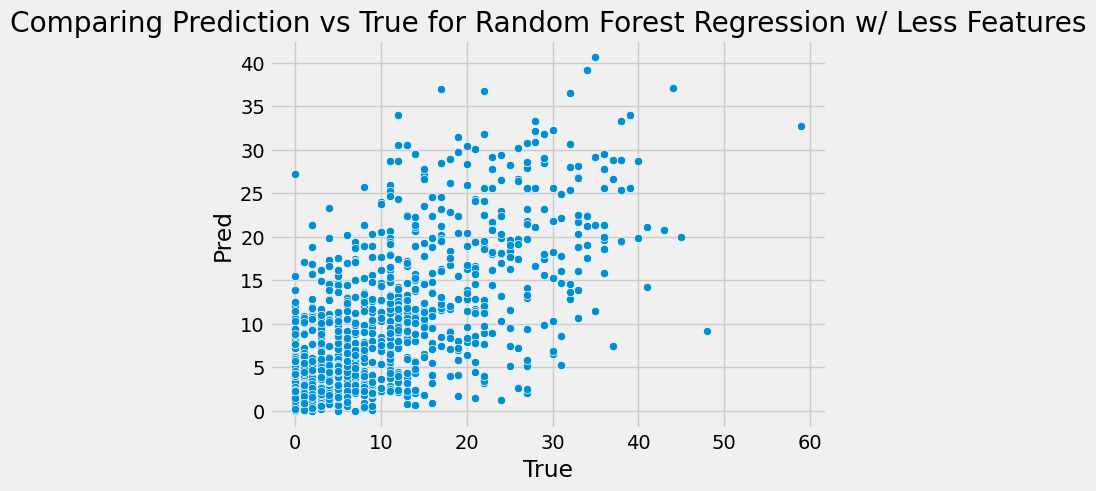

Random Forest Regression Performance on the test set: MAE = 4.143895099230457
Random Forest Regression Performance on test set: RMSE = 6.330629172709236


In [64]:
# In this cell, I will show you how much worse the model performs with a more reasonable amount of features
small_features = training_data[correlations_data.iloc[0:10].index].copy()
small_targets = pd.DataFrame(target_data['HR']).astype(float)
small_X_train, small_X_test, small_y_train, small_y_test = train_test_split(small_features, small_targets, test_size = 0.3, random_state = 42)

# Make scaler object with range of 0-1
small_scaler = MinMaxScaler(feature_range=(0, 1))
small_scaler.fit(small_X_train)

# Transform training and test data
small_X_train = small_scaler.transform(small_X_train)
small_X_test = small_scaler.transform(small_X_test)

# Convert y to 1D array
small_y_train = np.array(small_y_train).reshape((-1, ))
small_y_test = np.array(small_y_test).reshape((-1, ))

small_random_forest = RandomForestRegressor(random_state=100)
small_random_forest_mae, small_random_forest_rmse = fit_and_eval(small_random_forest, small_X_train, small_X_test, small_y_train, small_y_test, "Random Forest Regression w/ Less Features")

print(f'Random Forest Regression Performance on the test set: MAE = {str(small_random_forest_mae)}')
print(f'Random Forest Regression Performance on test set: RMSE = {str(small_random_forest_rmse)}')

<Figure size 800x600 with 0 Axes>

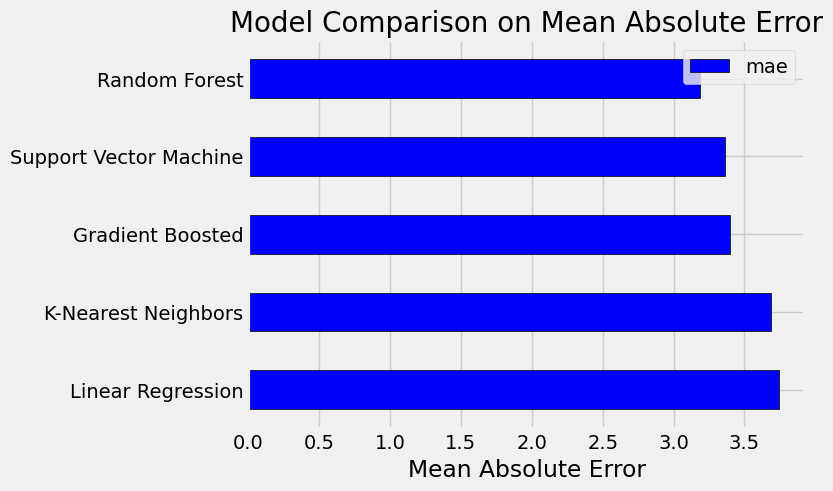

In [65]:
# Compare results of the model
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))

model_comparison_mae = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lin_reg_mae, svm_mae, random_forest_mae, 
                                         grad_boost_mae, knn_mae]})

# Bar chart of test mean absolute error
model_comparison_mae.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); 
plt.yticks(size = 14); 
plt.xlabel('Mean Absolute Error'); 
plt.xticks(size = 14)
plt.title('Model Comparison on Mean Absolute Error', size = 20);

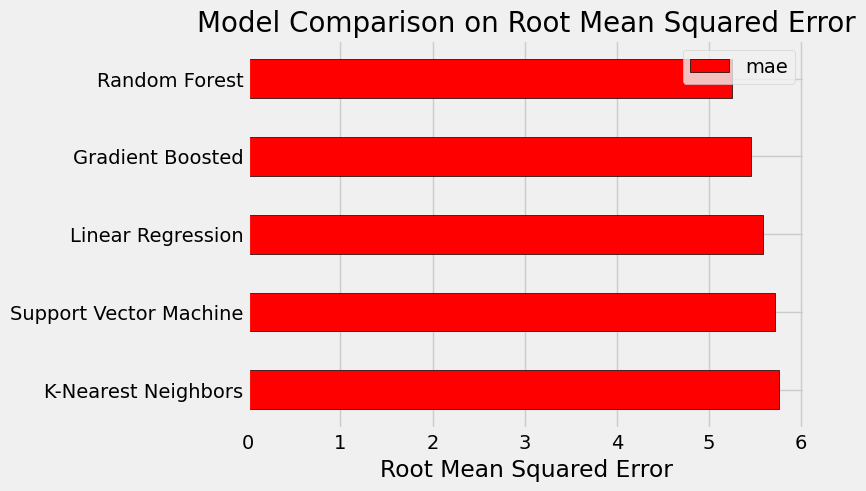

In [66]:
model_comparison_rmse = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lin_reg_rmse, svm_rmse, random_forest_rmse, 
                                         grad_boost_rmse, knn_rmse]})

# Bar chart of test mean absolute error
model_comparison_rmse.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); 
plt.yticks(size = 14); 
plt.xlabel('Root Mean Squared Error'); 
plt.xticks(size = 14)
plt.title('Model Comparison on Root Mean Squared Error', size = 20);

In [67]:
# function to measure the quality of a split
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

# Number of trees used in forest
n_estimators = [100, 500, 900, 1100, 1500]

# Max depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# The minimum number of samples required to split an internal node
min_samples_split = [2, 4, 6, 10]

#The number of features to consider when looking for the best split:
max_features = [1.0, 'sqrt', 'log2', None]

# Grid of hyperparameters to search
hyperparameter_grid = {'criterion':criterion,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [68]:


# Random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=random_forest,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=100)
random_cv.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': [1.0, 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=100, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [69]:
# Get cv results and sort by the mean test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,50.075338,1.007576,0.004666,0.001388,100,2,1,1.0,5,absolute_error,...,-2.960607,0.098697,1,-2.646344,-2.671694,-2.640347,-2.594914,-2.654860,-2.641632,0.025633
3,711.716791,19.022589,0.053417,0.003913,900,4,2,None,15,absolute_error,...,-2.990814,0.105007,2,-2.077920,-2.093589,-2.061969,-2.012924,-2.060577,-2.061396,0.027055
11,24.154693,0.206983,0.046783,0.003835,500,4,1,None,15,poisson,...,-3.013173,0.058853,3,-1.278286,-1.284728,-1.255408,-1.235423,-1.264594,-1.263688,0.017459
10,37.307889,0.327529,0.085069,0.008669,1100,10,8,1.0,15,friedman_mse,...,-3.026119,0.062753,4,-2.123002,-2.122024,-2.107889,-2.065785,-2.094535,-2.102647,0.021175
17,53.782491,0.372173,0.122789,0.005797,1500,10,6,1.0,15,squared_error,...,-3.033727,0.061991,5,-1.924371,-1.929841,-1.912687,-1.874054,-1.897874,-1.907765,0.020108
18,12.301841,0.248803,0.005195,0.000108,100,2,1,sqrt,10,absolute_error,...,-3.038189,0.103249,6,-2.085461,-2.107603,-2.085000,-2.030620,-2.080921,-2.077921,0.025434
12,19.271793,0.147206,0.042093,0.003113,500,4,4,1.0,15,friedman_mse,...,-3.042974,0.062368,7,-1.655862,-1.661676,-1.640274,-1.605008,-1.627606,-1.638085,0.020402
0,3.958716,0.049138,0.009940,0.002231,100,2,4,1.0,15,friedman_mse,...,-3.048548,0.055644,8,-1.657602,-1.671183,-1.646047,-1.618805,-1.639742,-1.646676,0.017580
2,3.985183,0.051245,0.010443,0.002526,100,10,4,None,15,friedman_mse,...,-3.051428,0.056787,9,-1.750839,-1.762750,-1.738435,-1.703320,-1.724445,-1.735958,0.020703
14,1.931237,0.035761,0.004529,0.001013,100,4,1,None,5,friedman_mse,...,-3.211159,0.073706,10,-2.866800,-2.876323,-2.876834,-2.819404,-2.859686,-2.859809,0.021185


In [70]:
# Show the best estimator's hyperparameters
random_cv.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=5, random_state=100)

In [71]:
# Retain all but one of the best hyperparameter setting
# Toggle 'min_samples_leaf' to see how performance is impacted
leaf_grid = {'min_samples_leaf': [1, 2, 3, 4,5]}
model = RandomForestRegressor(max_depth = 5,
                                  min_samples_split = 10,
                                  n_estimators=900,
                                  max_features = None,
                                  random_state = 60,
                                  criterion='absolute_error')
grid_search = GridSearchCV(estimator = model, param_grid=leaf_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


GridSearchCV(cv=4,
             estimator=RandomForestRegressor(criterion='absolute_error',
                                             max_depth=5, max_features=None,
                                             min_samples_split=10,
                                             n_estimators=900,
                                             random_state=60),
             n_jobs=-1, param_grid={'min_samples_leaf': [1, 2, 3, 4, 5]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

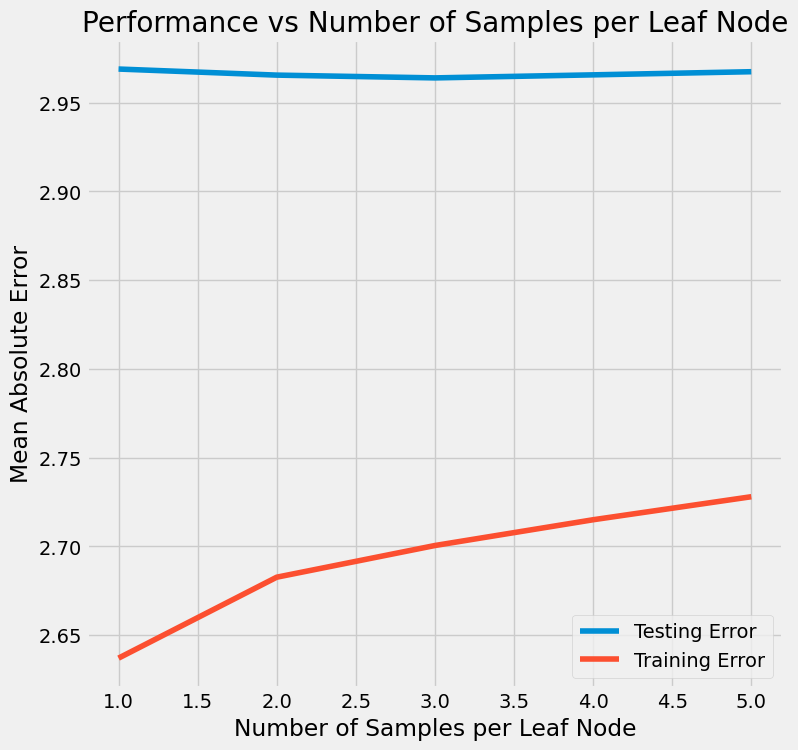

In [72]:
# Place results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot training and testing error v. # of trees
plt.figure(figsize=(8, 8))
plt.style.use('fivethirtyeight')
plt.plot(results['param_min_samples_leaf'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_min_samples_leaf'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Samples per Leaf Node'); 
plt.ylabel('Mean Absolute Error'); plt.legend();
plt.title('Performance vs Number of Samples per Leaf Node');

In [73]:
# Examine best results by mean test score
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
2,399.761411,16.876749,0.044757,0.003104,3,{'min_samples_leaf': 3},-2.826288,-2.954455,-3.118034,-2.957184,-2.963990,0.103475,1,-2.750527,-2.713327,-2.640627,-2.697191,-2.700418,0.039570
1,406.599868,12.296750,0.047027,0.007525,2,{'min_samples_leaf': 2},-2.831979,-2.951250,-3.122649,-2.956355,-2.965558,0.103453,2,-2.730139,-2.698566,-2.619778,-2.681762,-2.682561,0.040194
3,391.221326,10.496231,0.033982,0.003533,4,{'min_samples_leaf': 4},-2.829700,-2.956300,-3.117815,-2.959001,-2.965704,0.102186,3,-2.762017,-2.729044,-2.656838,-2.711859,-2.714939,0.038081
4,385.565139,10.072455,0.032687,0.001609,5,{'min_samples_leaf': 5},-2.828475,-2.965906,-3.118822,-2.956701,-2.967476,0.102890,4,-2.772119,-2.746339,-2.669627,-2.723599,-2.727921,0.037781
0,409.044671,13.504069,0.048261,0.009151,1,{'min_samples_leaf': 1},-2.837049,-2.951148,-3.125305,-2.962433,-2.968984,0.102718,5,-2.681660,-2.653461,-2.579250,-2.633399,-2.636943,0.037461


In [74]:
# Examine Default model vs our model

default_model = RandomForestRegressor(random_state = 100)

# Choose the best model
final_model = grid_search.best_estimator_

final_model



RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features=None, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=900, random_state=60)

In [75]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
2,399.761411,16.876749,0.044757,0.003104,3,{'min_samples_leaf': 3},-2.826288,-2.954455,-3.118034,-2.957184,-2.963990,0.103475,1,-2.750527,-2.713327,-2.640627,-2.697191,-2.700418,0.039570
1,406.599868,12.296750,0.047027,0.007525,2,{'min_samples_leaf': 2},-2.831979,-2.951250,-3.122649,-2.956355,-2.965558,0.103453,2,-2.730139,-2.698566,-2.619778,-2.681762,-2.682561,0.040194
3,391.221326,10.496231,0.033982,0.003533,4,{'min_samples_leaf': 4},-2.829700,-2.956300,-3.117815,-2.959001,-2.965704,0.102186,3,-2.762017,-2.729044,-2.656838,-2.711859,-2.714939,0.038081
4,385.565139,10.072455,0.032687,0.001609,5,{'min_samples_leaf': 5},-2.828475,-2.965906,-3.118822,-2.956701,-2.967476,0.102890,4,-2.772119,-2.746339,-2.669627,-2.723599,-2.727921,0.037781
0,409.044671,13.504069,0.048261,0.009151,1,{'min_samples_leaf': 1},-2.837049,-2.951148,-3.125305,-2.962433,-2.968984,0.102718,5,-2.681660,-2.653461,-2.579250,-2.633399,-2.636943,0.037461


In [76]:
# Create data frame to analyze feature importance
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'importance': final_model.feature_importances_})

# Let's see 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,RAR,0.572757
1,WAR,0.278766
2,L-WAR,0.067963
3,-WPA,0.008609
4,R,0.005960
5,OPS,0.005194
6,Off,0.004507
7,wRAA,0.003521
8,Bat,0.003209
9,WPA/LI,0.003125
